# Statistical Tests and Visualization for Q-Learning Strategy

## 1. Setup and Data Loading

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib import rcParams
from matplotlib.ticker import PercentFormatter
from scipy.stats import t, wilcoxon
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

# Load data
df = pd.read_csv("../results/runs/final/q_learning.csv")

# Type conversions
df["alpha"] = pd.to_numeric(df["alpha"], errors="coerce")
df["lambda"] = pd.to_numeric(df["lambda"], errors="coerce")
df["solved"] = df["solved"].astype(int)
df["presses_used"] = df["presses_used"].astype(int)
df["det_solvable"] = df["det_solvable"].astype(int)
df["board_id"] = df["board_id"].astype(int)

print(f"Total rows: {len(df)}")
print(f"Strategies: {sorted(df['strategy'].unique())}")
print(f"Kernels: {df['kernel'].unique()}")
print(f"Unique boards: {df['board_id'].nunique()}")
print(f"Parameter combinations: {df.groupby(['alpha', 'lambda']).ngroups}")
print(f"\nData loaded successfully.")

Total rows: 600000
Strategies: ['greedy', 'q_learning_3x3']
Kernels: ['exp']
Unique boards: 10000
Parameter combinations: 30

Data loaded successfully.


In [2]:
strategy_solve_rates = (
    df.groupby("strategy")["solved"].mean().sort_values(ascending=False)
)

print("Overall solve rates by strategy:")
print(strategy_solve_rates)

# Average solve rate per board across all (α, λ) combinations
board_strategy = df.groupby(["board_id", "strategy"], as_index=False)[
    "solved"
].mean()

sorted_strategies = strategy_solve_rates.sort_values(ascending=False)

# Pivot to wide format: rows=boards, columns=strategies
pivot = board_strategy.pivot(
    index="board_id", columns="strategy", values="solved"
)

pivot = pivot[sorted_strategies.index]

print(
    f"\nPivot table reordered with {len(pivot)} boards and {len(pivot.columns)} strategies"
)

Overall solve rates by strategy:
strategy
greedy            0.99165
q_learning_3x3    0.98608
Name: solved, dtype: float64

Pivot table reordered with 10000 boards and 2 strategies


In [ ]:
sns.set_theme(style="whitegrid")  # or "ticks" if you prefer less grid
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 10,
        "axes.labelsize": 12,
        "axes.labelweight": "bold",
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        # "axes.linewidth": 0.8,
        # "grid.linewidth": 0.6,
        "savefig.dpi": 300,
    }
)

# Create a consistent color mapping for strategies
STRATEGY_COLORS = {
    strategy: color
    for strategy, color in zip(
        sorted(df["strategy"].unique()),
        sns.color_palette("deep", df["strategy"].nunique()),
    )
}


def finalize_ax(ax, xlabel=None, ylabel=None, xgrid=False, ygrid=False):
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(False)
    if xgrid:
        ax.grid(axis="x", linestyle="--")
    if ygrid:
        ax.grid(axis="y", linestyle="--")
    sns.despine(ax=ax)


MY_WIDTH = 5.87 * 1.5  # in inches
ratio = 4 / 3  # height/width ratio
MY_HEIGHT = MY_WIDTH / ratio

print(f"Figure size: {MY_WIDTH:.2f} x {MY_HEIGHT:.2f} inches")
# Print in centimeters
print(f"Figure size: {MY_WIDTH * 2.54:.2f} x {MY_HEIGHT * 2.54:.2f} cm")

Figure size: 8.80 x 6.60 inches
Figure size: 22.36 x 16.77 cm


## 2. Statistical Helper Functions

In [4]:
def calculate_strategy_metrics_with_ci(
    df: pd.DataFrame,
    metric: str,
    filter_solved: bool = False,
    alpha: float = 0.05,
) -> pd.DataFrame:
    """
    Calculate mean and confidence intervals for each strategy across given metrics.
    """
    # Filter data if needed
    data = df[df["solved"] == 1].copy() if filter_solved else df.copy()

    results = []

    for strategy in sorted(data["strategy"].unique()):
        strat_data = data[data["strategy"] == strategy]

        # Aggregate by board
        board_values = strat_data.groupby("board_id")[metric].mean()
        n_boards = len(board_values)

        if n_boards == 0:
            results.append(
                {
                    "strategy": strategy,
                    "metric": metric,
                    "mean": np.nan,
                    "ci_low": np.nan,
                    "ci_high": np.nan,
                    "n_boards": 0,
                }
            )
            continue

        mean_val = board_values.mean()

        # Calculate t-distribution based confidence interval
        sem = board_values.sem()
        t_crit = t.ppf(1 - alpha / 2, df=n_boards - 1)
        ci_low = mean_val - t_crit * sem
        ci_high = mean_val + t_crit * sem

        # Clip to [0, 1] for proportions
        if metric == "solved":
            ci_low = max(0, ci_low)
            ci_high = min(1, ci_high)

        results.append(
            {
                "strategy": strategy,
                "metric": metric,
                "mean": mean_val,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "n_boards": n_boards,
            }
        )

    return pd.DataFrame(results)

In [5]:
def pairwise_baseline_comparison(
    df: pd.DataFrame,
    metric: str,
    baseline: str = "greedy",
    metric_name: str | None = None,
    filter_solved: bool = False,
    min_pairs: int = 10,
    alpha: float = 0.05,
) -> pd.DataFrame:
    """
    Compare all strategies against a baseline using paired Wilcoxon tests.

    Parameters:
    -----------
    df : DataFrame
        Raw data with columns: board_id, strategy, and the metric column
    metric : str
        Column name to compare (e.g., 'solved', 'presses_used')
    baseline : str
        Baseline strategy name (default: 'greedy')
    metric_name : str
        Display name for the metric (default: same as metric)
    filter_solved : bool
        If True, only include solved instances (for presses comparison)
    min_pairs : int
        Minimum number of paired observations required

    Returns:
    --------
    DataFrame with comparison results including p-values and effect sizes
    """
    if metric_name is None:
        metric_name = metric

    # Filter if needed
    data = df[df["solved"] == 1].copy() if filter_solved else df.copy()

    # Create pivot table: rows=boards, columns=strategies
    pivot = (
        data.groupby(["board_id", "strategy"])[metric]
        .mean()
        .unstack("strategy")
    )

    if baseline not in pivot.columns:
        raise ValueError(f"Baseline strategy '{baseline}' not found")

    # Get other strategies
    other_strategies = [s for s in pivot.columns if s != baseline]

    # Pairwise comparisons
    results = []
    for strategy in other_strategies:
        paired = pivot[[baseline, strategy]].dropna()

        if len(paired) < min_pairs:
            continue

        # Wilcoxon test
        _, p_val = wilcoxon(
            paired[strategy],
            paired[baseline],
            zero_method="wilcox",
            alternative="two-sided",
        )

        # Descriptive statistics
        diff = paired[strategy] - paired[baseline]
        mean_diff = diff.mean()
        median_diff = diff.median()
        sem = diff.sem()
        t_crit = t.ppf(1 - alpha / 2, df=len(diff) - 1)
        ci_low = mean_diff - t_crit * sem
        ci_high = mean_diff + t_crit * sem

        # Clip to [-1, 1] for proportions
        if metric == "solved":
            ci_low = max(-1, ci_low)
            ci_high = min(1, ci_high)

        # Cohen's dz
        d_z = paired_cohens_dz(diff)

        # Rank-biserial correlation
        r_rb = rank_biserial_from_diffs(diff)

        results.append(
            {
                "strategy": strategy,
                f"mean_{baseline}": paired[baseline].mean(),
                "mean_strategy": paired[strategy].mean(),
                "mean_diff": mean_diff,
                "median_diff": median_diff,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "n_boards": len(paired),
                "p_value": p_val,
                "cohens_dz": d_z,
                "rank_biserial_r": r_rb,
            }
        )

    results_df = pd.DataFrame(results)

    # Holm correction
    _, results_df["p_holm"], _, _ = multipletests(
        results_df["p_value"], alpha=0.05, method="holm"
    )
    results_df["significant"] = results_df["p_holm"] < 0.05

    return results_df


def paired_cohens_dz(diff: pd.Series) -> float:
    # Cohen's dz for paired samples: mean(diff) / std(diff)
    sd = diff.std(ddof=1)
    if sd == 0 or np.isnan(sd):
        return np.nan
    return diff.mean() / sd


def rank_biserial_from_diffs(diff: pd.Series) -> float:
    """Compute rank-biserial correlation from paired differences."""
    d = diff.dropna()
    d = d[d != 0]
    if len(d) == 0:
        return np.nan

    abs_d = d.abs()
    ranks = abs_d.rank(method="average")  # average ranks for ties
    W_plus = ranks[d > 0].sum()
    W_minus = ranks[d < 0].sum()
    return float((W_plus - W_minus) / (W_plus + W_minus))

## 3. Solve Rate Comparison

In [6]:
solve_comparison = pairwise_baseline_comparison(
    df=df, metric="solved", baseline="greedy", metric_name="solve_rate"
)

print(
    "\nInterpretation: Positive = strategy solves MORE | Negative = solves LESS\n"
)

solve_comparison = solve_comparison.sort_values("mean_diff", ascending=False)

# Display results - dynamically select the mean column for each strategy
display_cols = [
    "strategy",
    "mean_greedy",
    "mean_strategy",
    "mean_diff",
    "median_diff",
    "ci_low",
    "ci_high",
    "n_boards",
    "p_holm",
    "significant",
    "cohens_dz",
    "rank_biserial_r",
]
solve_comparison[display_cols]


Interpretation: Positive = strategy solves MORE | Negative = solves LESS



,strategy,mean_greedy,mean_strategy,mean_diff,median_diff,ci_low,ci_high,n_boards,p_holm,significant,cohens_dz,rank_biserial_r
0,q_learning_3x3,0.99165,0.98608,-0.00557,0.0,-0.006063,-0.005077,10000,6.769116e-103,True,-0.221323,-0.337295


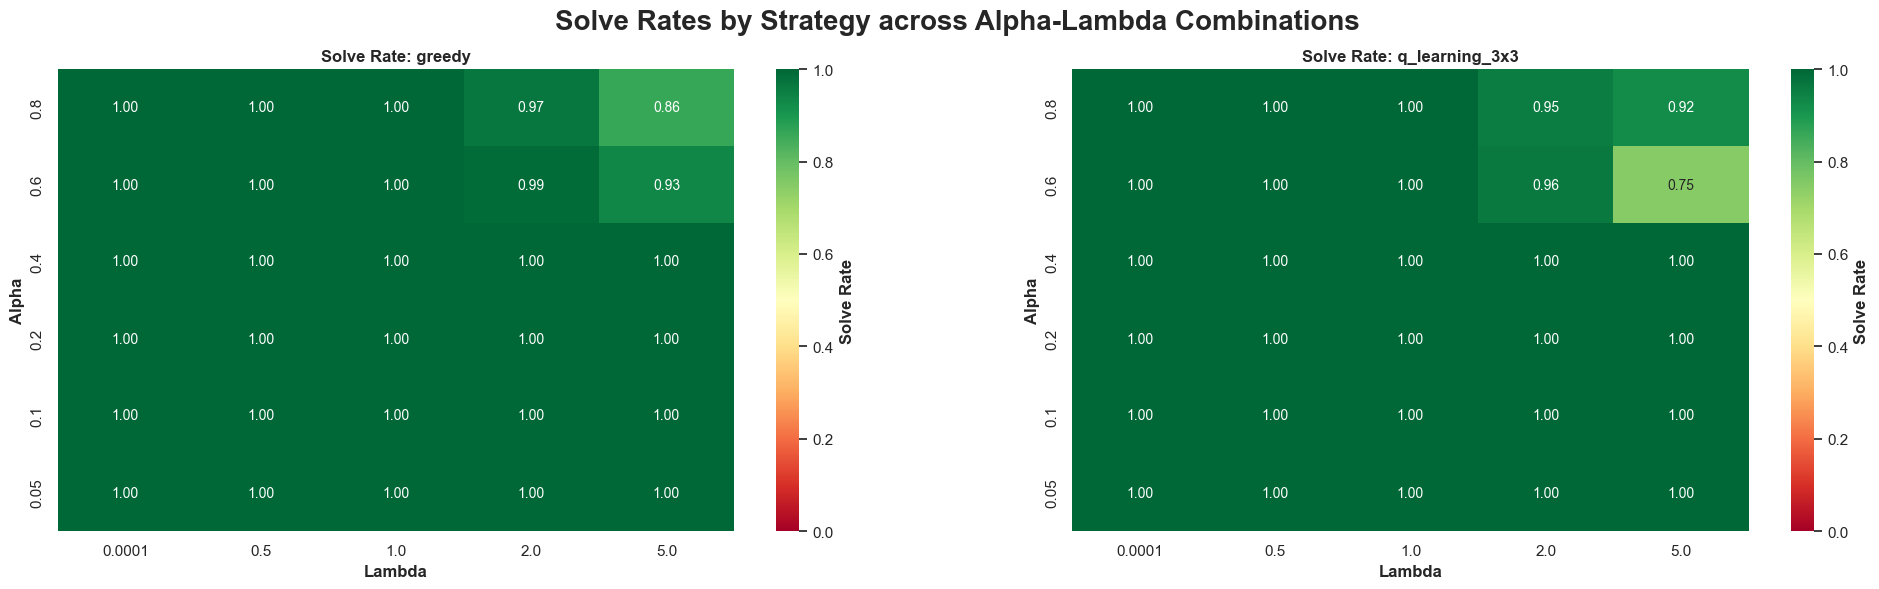

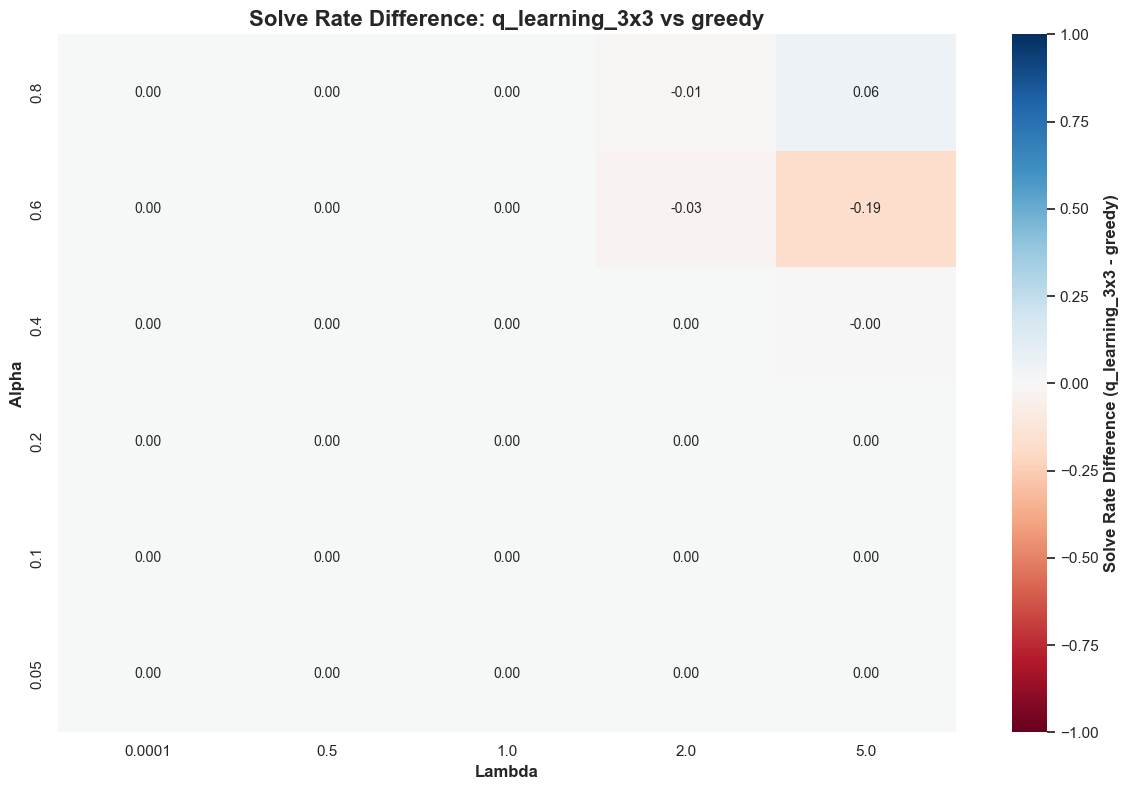

In [7]:
# Create a heatmap of the solve rates per alpha-lambda combination by strategy
strategies = df["strategy"].unique()

fig, axes = plt.subplots(1, len(strategies), figsize=(12 * len(strategies), 6))
if len(strategies) == 1:
    axes = [axes]

for idx, strategy in enumerate(sorted(strategies)):
    strategy_df = df[df["strategy"] == strategy]

    pivot_heatmap = strategy_df.pivot_table(
        index="alpha",
        columns="lambda",
        values="solved",
        aggfunc="mean",
    )

    sns.heatmap(
        pivot_heatmap,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        cbar_kws={"label": "Solve Rate"},
        ax=axes[idx],
        vmin=0,
        vmax=1,
    )
    axes[idx].invert_yaxis()
    axes[idx].set_title(f"Solve Rate: {strategy}", fontweight="bold")
    axes[idx].set_xlabel("Lambda")
    axes[idx].set_ylabel("Alpha")

fig.suptitle(
    "Solve Rates by Strategy across Alpha-Lambda Combinations",
    fontweight="bold",
    fontsize=20,
)
plt.show()


# Plot a difference heatmap between the greedy baseline and q_learning_3x3
baseline_strategy = "greedy"
strategy_df_comparison = df[
    df["strategy"].isin([baseline_strategy, "q_learning_3x3"])
]

pivot_baseline = strategy_df_comparison[
    strategy_df_comparison["strategy"] == baseline_strategy
].pivot_table(
    index="alpha",
    columns="lambda",
    values="solved",
    aggfunc="mean",
)

pivot_strategy = strategy_df_comparison[
    strategy_df_comparison["strategy"] == "q_learning_3x3"
].pivot_table(
    index="alpha",
    columns="lambda",
    values="solved",
    aggfunc="mean",
)

# Calculate difference
pivot_diff = pivot_strategy - pivot_baseline

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    pivot_diff,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    center=0,
    cbar_kws={
        "label": f"Solve Rate Difference (q_learning_3x3 - {baseline_strategy})"
    },
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.invert_yaxis()
ax.set_title(
    f"Solve Rate Difference: q_learning_3x3 vs {baseline_strategy}",
    fontweight="bold",
    fontsize=16,
)
ax.set_xlabel("Lambda")
ax.set_ylabel("Alpha")

plt.tight_layout()
plt.show()

## 4. Press Analysis

In [8]:
presses_comparison = pairwise_baseline_comparison(
    df=df,
    metric="presses_used",
    baseline="greedy",
    metric_name="presses",
    filter_solved=True,
)

print(
    "\nInterpretation: Positive = strategy uses MORE presses | Negative = FEWER presses\n"
)
presses_comparison[
    [
        "strategy",
        "mean_greedy",
        "mean_strategy",
        "mean_diff",
        "median_diff",
        "ci_low",
        "ci_high",
        "n_boards",
        "p_holm",
        "significant",
        "cohens_dz",
        "rank_biserial_r",
    ]
].sort_values("mean_diff", ascending=True)


Interpretation: Positive = strategy uses MORE presses | Negative = FEWER presses



,strategy,mean_greedy,mean_strategy,mean_diff,median_diff,ci_low,ci_high,n_boards,p_holm,significant,cohens_dz,rank_biserial_r
0,q_learning_3x3,33.960787,33.778655,-0.182132,-0.1,-0.43669,0.072427,10000,0.194481,False,-0.014025,-0.014984


In [9]:
# Prepare survival data: Use individual observations, not aggregated
max_steps = df["presses_used"].max()

# Work with raw data, but set censoring correctly
survival_df = df.copy()

# Remove strategies with solve rate < 0.05
""" strategy_solve_rates = survival_df.groupby("strategy")["solved"].mean()
low_rate_strategies = strategy_solve_rates[
    strategy_solve_rates < 0.05
].index.tolist()
survival_df = survival_df[~survival_df["strategy"].isin(low_rate_strategies)] """

# For unsolved boards, set presses to max_steps (censoring point)
survival_df.loc[survival_df["solved"] == 0, "presses_used"] = max_steps

# Now you have all 30 parameter combinations per board
print(f"Total observations for survival analysis: {len(survival_df)}")
print(f"Events (solved): {survival_df['solved'].sum()}")
print(f"Censored (not solved): {(1-survival_df['solved']).sum()}")

Total observations for survival analysis: 600000
Events (solved): 593319
Censored (not solved): 6681


## 5. Time per Action Analysis

In [10]:
# Create a temporary column with time in microseconds
df["time_per_action_us"] = df["time_per_action_ms"] * 1000

action_time_comparison = pairwise_baseline_comparison(
    df=df,
    metric="time_per_action_us",
    baseline="greedy",
    metric_name="time per action (μs)",
    filter_solved=False,
)

action_time_comparison[
    [
        "strategy",
        "mean_greedy",
        "mean_strategy",
        "mean_diff",
        "median_diff",
        "ci_low",
        "ci_high",
        "n_boards",
        "p_holm",
        "significant",
        "rank_biserial_r",
    ]
].sort_values("mean_diff", ascending=True)

,strategy,mean_greedy,mean_strategy,mean_diff,median_diff,ci_low,ci_high,n_boards,p_holm,significant,rank_biserial_r
0,q_learning_3x3,18.459315,24.208824,5.749509,5.578876,5.669324,5.829694,10000,0.0,True,0.975378


## 6. Visualization in one plot

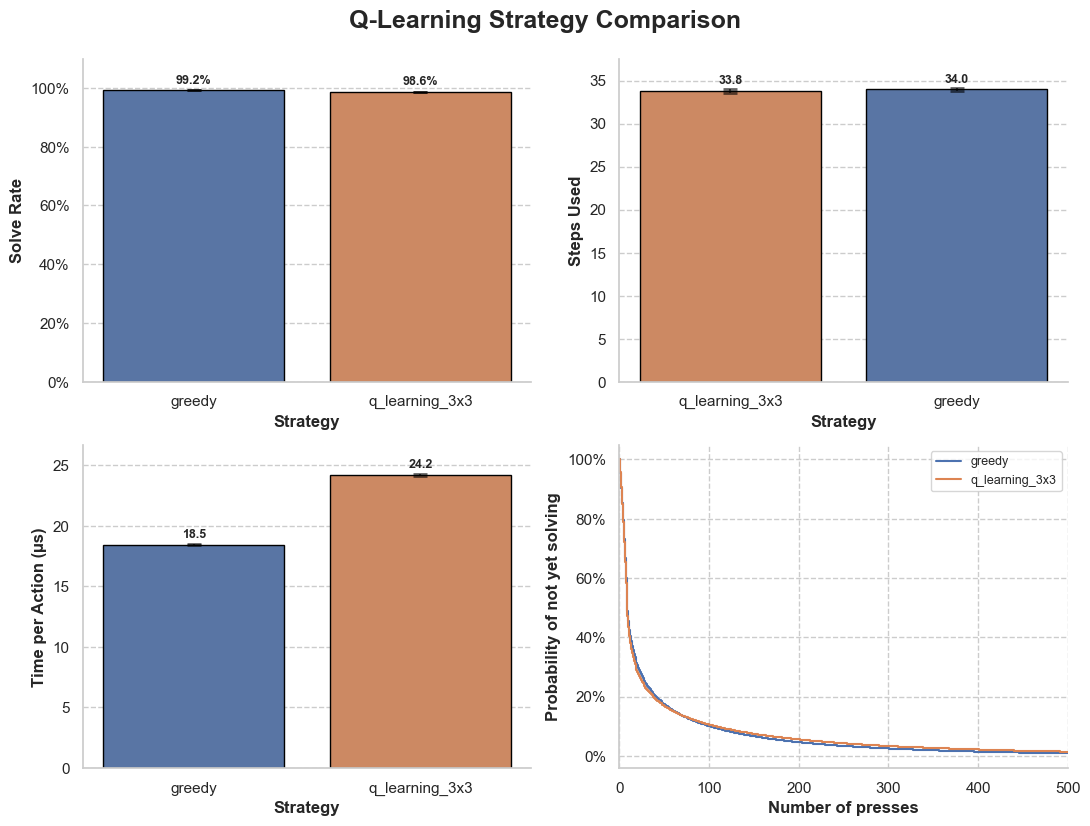

In [ ]:
# Create a single figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(MY_WIDTH * 1.25, MY_HEIGHT * 1.25))
fig.suptitle(
    "Q-Learning Strategy Comparison", fontsize=18, fontweight="bold", y=0.995
)

# Flatten axes for easier iteration
ax1, ax2, ax3, ax4 = axes.flatten()

# ===== Plot 1: Solve Rates =====

solve_metrics = calculate_strategy_metrics_with_ci(df, metric="solved")
solve_metrics = solve_metrics.sort_values("mean", ascending=False)

solve_metrics["error_low"] = solve_metrics["mean"] - solve_metrics["ci_low"]
solve_metrics["error_high"] = solve_metrics["ci_high"] - solve_metrics["mean"]

bars1 = sns.barplot(
    data=solve_metrics,
    x="strategy",
    y="mean",
    hue="strategy",
    palette=STRATEGY_COLORS,
    edgecolor="black",
    legend=False,
    ax=ax1,
)

for container in bars1.containers:
    labels = [f"{v.get_height()*100:.1f}%" for v in container]
    bars1.bar_label(
        container,  # pyright: ignore[reportArgumentType]
        labels=labels,
        label_type="edge",
        padding=3,
        fontsize=9,
        fontweight="bold",
        clip_on=False,
    )

ax1.errorbar(
    range(len(solve_metrics)),
    solve_metrics["mean"],
    yerr=[solve_metrics["error_low"], solve_metrics["error_high"]],
    fmt="none",
    ecolor="black",
    capsize=5,
    capthick=2,
    alpha=0.6,
)

ax1.set_ylim(0, 1.1)
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
finalize_ax(ax1, xlabel="Strategy", ylabel="Solve Rate", ygrid=True)

# ===== Plot 2: Presses Used =====
press_metrics = calculate_strategy_metrics_with_ci(
    df, metric="presses_used", filter_solved=True
)
press_metrics = press_metrics.sort_values("mean", ascending=True)

press_metrics["error_low"] = press_metrics["mean"] - press_metrics["ci_low"]
press_metrics["error_high"] = press_metrics["ci_high"] - press_metrics["mean"]

bars2 = sns.barplot(
    data=press_metrics,
    x="strategy",
    y="mean",
    hue="strategy",
    palette=STRATEGY_COLORS,
    edgecolor="black",
    legend=False,
    ax=ax2,
)

for container in bars2.containers:
    bars2.bar_label(
        container,  # pyright: ignore[reportArgumentType]
        fmt="{:.1f}",
        label_type="edge",
        padding=3,
        fontsize=9,
        fontweight="bold",
        clip_on=False,
    )

ax2.errorbar(
    range(len(press_metrics)),
    press_metrics["mean"],
    yerr=[press_metrics["error_low"], press_metrics["error_high"]],
    fmt="none",
    ecolor="black",
    capsize=5,
    capthick=2,
    alpha=0.6,
)

ax2.set_ylim(0, press_metrics["ci_high"].max() * 1.1)
finalize_ax(ax2, xlabel="Strategy", ylabel="Steps Used", ygrid=True)

# ===== Plot 3: Time per Action =====
time_metrics = calculate_strategy_metrics_with_ci(
    df, metric="time_per_action_us"
)
time_metrics = time_metrics.sort_values("mean", ascending=True)

# Calculate error bar sizes
time_metrics["error_low"] = time_metrics["mean"] - time_metrics["ci_low"]
time_metrics["error_high"] = time_metrics["ci_high"] - time_metrics["mean"]

sns.barplot(
    data=time_metrics,
    x="strategy",
    y="mean",
    hue="strategy",
    palette=STRATEGY_COLORS,
    edgecolor="black",
    legend=False,
    ax=ax3,
)

for container in ax3.containers:
    ax3.bar_label(
        container,  # pyright: ignore[reportArgumentType]
        fmt="{:.1f}",
        label_type="edge",
        padding=3,
        fontsize=9,
        fontweight="bold",
        clip_on=False,
    )

ax3.errorbar(
    range(len(time_metrics)),
    time_metrics["mean"],
    yerr=[time_metrics["error_low"], time_metrics["error_high"]],
    fmt="none",
    ecolor="black",
    capsize=5,
    capthick=2,
    alpha=0.6,
)

ax3.set_ylim(0, time_metrics["ci_high"].max() * 1.1)
finalize_ax(ax3, xlabel="Strategy", ylabel="Time per Action (µs)", ygrid=True)

# ===== Plot 4: Survival Curves =====
kmf = KaplanMeierFitter()

for strategy in sorted(survival_df["strategy"].unique()):
    strategy_data = survival_df[survival_df["strategy"] == strategy]

    kmf.fit(
        durations=strategy_data["presses_used"],
        event_observed=strategy_data["solved"],
        label=strategy,
    )
    kmf.plot_survival_function(
        ax=ax4, ci_show=False, color=STRATEGY_COLORS[strategy]
    )

ax4.legend(fontsize=9)
ax4.set_xlim(0, max_steps)
ax4.yaxis.set_major_formatter(PercentFormatter(1.0))
finalize_ax(
    ax4,
    xlabel="Number of presses",
    ylabel="Probability of not yet solving",
    xgrid=True,
    ygrid=True,
)

plt.tight_layout()
plt.savefig(
    "../results/plots/q_learning_comparison.png", dpi=300, bbox_inches="tight"
)
plt.show()